In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data

from spectral_cube import SpectralCube


#from astroquery.esasky import ESASky
#from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp


In [2]:
data = fits.open('/home/patito/Documents/datoselectivo/cubo/jellifysh.fits')

Cubo = SpectralCube.read(data[1])

data.close()

In [3]:
#latitud y longitud de la imagen, se ponen las unidades en astropy
lat_range = [21.141321,21.159599] * u.deg 
lon_range = [354.092428,354.111908] * u.deg

In [4]:
#sub cubo con todo el cubo
sub_cube = Cubo.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])

print(sub_cube)

SpectralCube with shape=(3682, 330, 328) and unit=1e-20 erg / (Angstrom s cm2):
 n_x:    328  type_x: RA---TAN  unit_x: deg    range:   354.092428 deg:  354.111908 deg
 n_y:    330  type_y: DEC--TAN  unit_y: deg    range:    21.141321 deg:   21.159599 deg
 n_s:   3682  type_s: AWAV      unit_s: Angstrom  range:     4750.401 Angstrom:    9351.651 Angstrom


In [5]:
sub_cube_slab = sub_cube.spectral_slab(6931*u.AA , 7001*u.AA)

print(sub_cube_slab)

SpectralCube with shape=(57, 330, 328) and unit=1e-20 erg / (Angstrom s cm2):
 n_x:    328  type_x: RA---TAN  unit_x: deg    range:   354.092428 deg:  354.111908 deg
 n_y:    330  type_y: DEC--TAN  unit_y: deg    range:    21.141321 deg:   21.159599 deg
 n_s:     57  type_s: AWAV      unit_s: Angstrom  range:     6930.401 Angstrom:    7000.401 Angstrom


In [6]:
ha_cube.with_spectral_unit?

Object `ha_cube.with_spectral_unit` not found.


In [7]:
ha_cube = sub_cube_slab.with_spectral_unit(u.km/u.s ,velocity_convention='optical',rest_value=6563*u.AA)  

In [8]:
ha_subcube = ha_cube.spectral_slab(6931*u.AA , 7001*u.AA)  

UnitsError: Spectral axis is in velocity units and 'value' is in frequency-equivalent units - use SpectralCube.with_spectral_unit first to convert the cube to frequency-equivalent units, or search for a velocity instead

In [ ]:
moment_0 = sub_cube_slab.with_spectral_unit(u.AA).moment(order=0)  # Zero-th moment 
moment_1 = sub_cube_slab.with_spectral_unit(u.AA).moment(order=1)  # First moment


# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits') 
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  1e-20 erg / (s cm2)
Moment_1 has units of:  Angstrom


/home/patito/.local/lib/python3.10/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


In [ ]:
print(moment_1.wcs)  # Examine the WCS object associated with the moment map

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 354.101834 21.15036 
CRPIX : 170.105680854728 163.694055524468 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -5.55555555555556e-05 5.55555555555556e-05 
NAXIS : 0  0


In [ ]:
moment_0

<Projection [[       nan,        nan,        nan, ...,        nan,
                     nan,        nan],
             [       nan,        nan,        nan, ..., -136.81099,
                     nan,        nan],
             [       nan,        nan,        nan, ..., -215.84946,
                     nan,        nan],
             ...,
             [       nan,        nan,        nan, ...,        nan,
                     nan,        nan],
             [       nan,        nan,        nan, ...,        nan,
                     nan,        nan],
             [       nan,        nan,        nan, ...,        nan,
                     nan,        nan]] 1e-20 erg / (s cm2)>

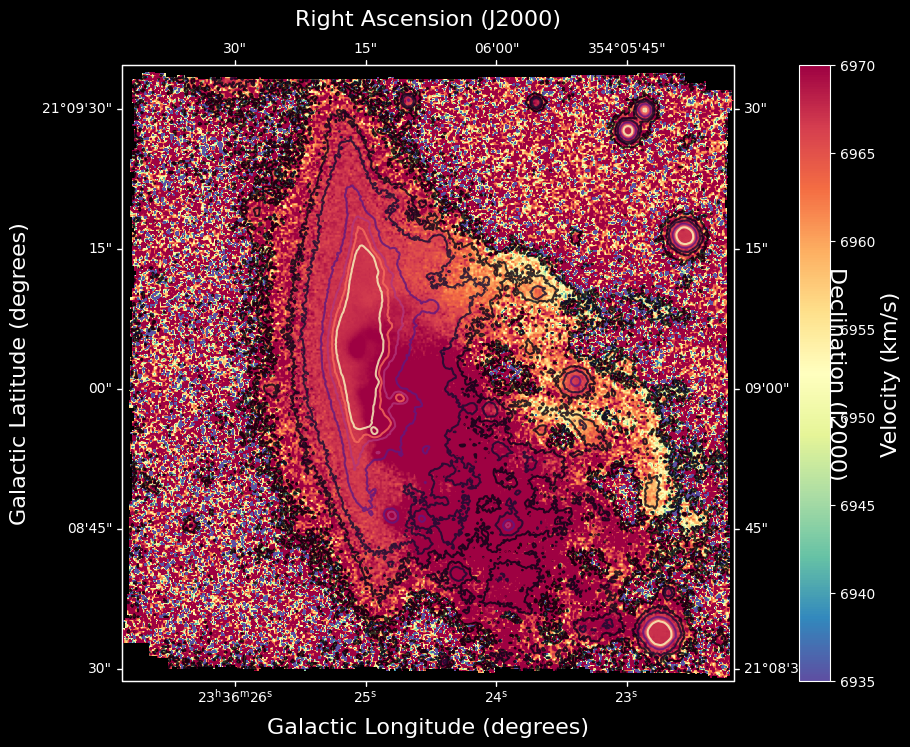

In [ ]:
%matplotlib inline
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='Spectral_r', vmin=6935, vmax=6970)
#ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
#overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours 
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='magma', alpha=0.8, levels=levels)

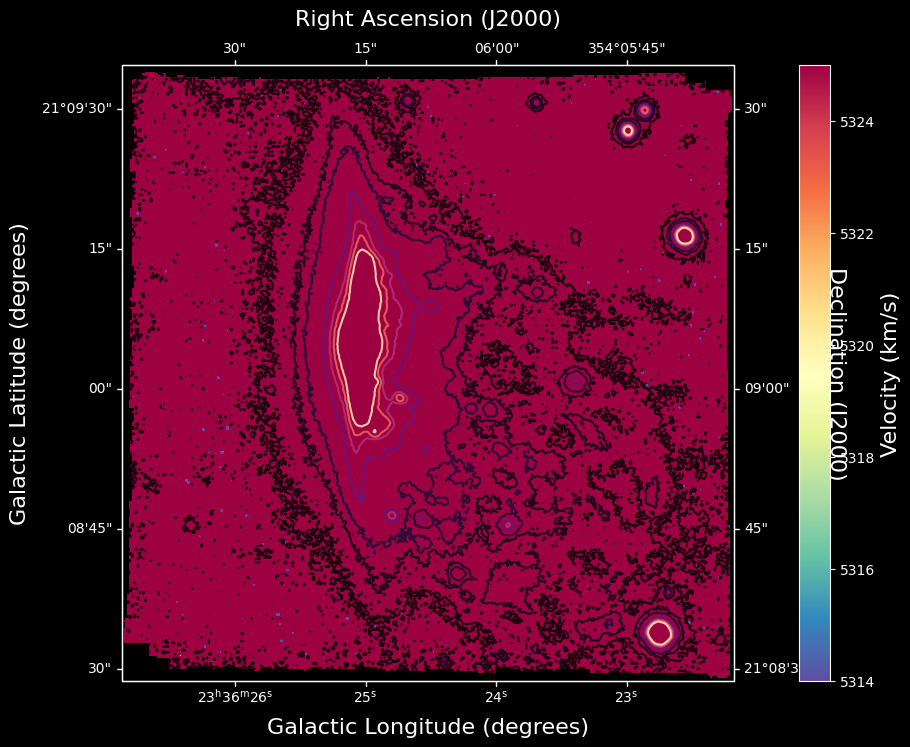

In [ ]:
%matplotlib inline
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='Spectral_r', vmin=5314, vmax=5325)
#ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
#overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours 
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='magma', alpha=0.8, levels=levels)